In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os


import tensorflow as tf
from keras.models import Model


GPU CHECK 

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [8]:
#Current working directory
cwd= os.getcwd()
print(cwd)

/home/eliascc/Codes/MicrographSegmentation_UNet


PATH TO DATASET

In [9]:
cwd_imgTrain = cwd + '/data/img/img_train/'
cwd_imgVal = cwd + '/data/img/img_valid/'

cwd_maskTrain = cwd +'/data/mask/mask_train/'
cwd_maskVal =  cwd + '/data/mask/mask_valid/'

LOADING DATASET INTO LIST

In [10]:
train_images = []
files = os.listdir(cwd_imgTrain)

files.sort()

for file in files:
  img = cv.imread(cwd_imgTrain + file, cv.IMREAD_COLOR)
  #print(file)
  train_images.append(img)

train_images = np.array(train_images)
print("-----------------")
train_mask = []
files = os.listdir(cwd_maskTrain)
files.sort()
for file in files:
  img = cv.imread(cwd_maskTrain + file, cv.IMREAD_GRAYSCALE)
  #print(file)
  train_mask.append(img)

train_mask = np.array(train_mask)
print("-----------------")
val_images = []
files = os.listdir(cwd_imgVal)
files.sort()
for file in files:
  img = cv.imread(cwd_imgVal + file, cv.IMREAD_COLOR)
  #print(file)
  val_images.append(img)

val_images = np.array(val_images)
print("-----------------")
val_mask = []
files = os.listdir(cwd_maskVal)
files.sort()
for file in files:
  img = cv.imread(cwd_maskVal + file, cv.IMREAD_GRAYSCALE)
  #print(file)
  val_mask.append(img)

val_mask = np.array(val_mask)
print("-----------------")

-----------------
-----------------
-----------------
-----------------


In [11]:
print("Shape of training images: ",train_images.shape)

print("Shape of training mask: ",train_mask.shape)

print("Shape of validation images: ",val_images.shape)

print("Shape of validation mask: ",val_mask.shape)

Shape of training images:  (160, 256, 256, 3)
Shape of training mask:  (160, 256, 256)
Shape of validation images:  (40, 256, 256, 3)
Shape of validation mask:  (40, 256, 256)


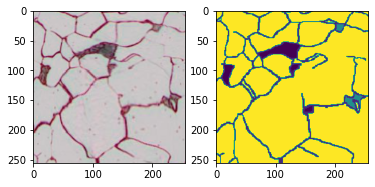

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(train_images[1])
ax2.imshow(train_mask[1])

In [15]:
from sklearn.preprocessing import LabelEncoder


labelencoder = LabelEncoder()
n, h, w = train_mask.shape
train_masks_reshaped = train_mask.reshape(-1,1)
print("Number of images:",n)
print("After reshape:", train_masks_reshaped.shape)

train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

print("Unique train mask : ",np.unique(train_masks_encoded_original_shape))

n, h, w = val_mask.shape
valid_masks_reshaped = val_mask.reshape(-1,1)
print("Number of images:",n)
print("After reshape:", valid_masks_reshaped.shape)

valid_masks_reshaped_encoded = labelencoder.fit_transform(valid_masks_reshaped)
valid_masks_encoded_original_shape = valid_masks_reshaped_encoded.reshape(n, h, w)

print("Unique val mask : ",np.unique(valid_masks_encoded_original_shape))


Number of images: 160
After reshape: (10485760, 1)


/home/eliascc/.local/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Unique train mask :  [0 1 2 3]
Number of images: 40
After reshape: (2621440, 1)
Unique val mask :  [0 1 2 3]


In [16]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
valid_masks_input = np.expand_dims(valid_masks_encoded_original_shape, axis=3)

print("Shape of training images: ",train_images.shape)

print("Shape of training mask: ",train_masks_input.shape)

print("Shape of validation images: ",val_images.shape)

print("Shape of validation mask: ",valid_masks_input.shape)

Shape of training images:  (160, 256, 256, 3)
Shape of training mask:  (160, 256, 256, 1)
Shape of validation images:  (40, 256, 256, 3)
Shape of validation mask:  (40, 256, 256, 1)


In [17]:
X_train , Y_train = train_images, train_masks_input
X_val , Y_val = val_images , valid_masks_input

In [14]:
from keras.utils.np_utils import to_categorical

n_classes = 4

train_mask_cat = to_categorical(Y_train, num_classes=n_classes)
Y_train_cat = train_mask_cat.reshape((Y_train.shape[0], Y_train.shape[1], Y_train.shape[2], n_classes))

test_masks_cat = to_categorical(Y_val, num_classes=n_classes)
Y_val_cat = test_masks_cat.reshape((Y_val.shape[0], Y_val.shape[1], Y_val.shape[2], n_classes))

In [15]:
  import segmentation_models as sm
  sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


LOSSES FUNCTIONS

In [16]:
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

from sklearn.utils import class_weight


#class_weights = class_weight.compute_class_weight('balanced',np.unique(train_masks_reshaped_encoded),train_masks_reshaped_encoded)


class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_masks_reshaped_encoded),
                                        y = train_masks_reshaped_encoded                                                    
                                    )
#class_weights = dict(zip(np.unique(train_masks_reshaped_encoded), class_weights)),

print("Class weights are...:", class_weights)

weights = class_weights
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()

total_loss = dice_loss + (1 * focal_loss)  #

metrics=['accuracy', jacard_coef]

Class weights are...: [2.49407744 2.29327669 3.07810089 0.35234626]


BUILDING MODEL

In [ ]:
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)
n_classes = 4 
# preprocess input
X_train_prepr = preprocess_input(X_train)
X_val_prepr = preprocess_input(X_val)

# define model
modelUnet = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

# compile keras model with defined optimozer, loss and metrics

#modelUnet.compile(optimizer='adam', loss=total_loss, metrics=metrics)
modelUnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
#print(modelUnet.summary())

In [ ]:
history = modelUnet.fit(X_train_prepr, Y_train_cat,
          batch_size=1, 
          epochs=100,
          verbose=1,
          validation_data=(X_val_prepr, Y_val_cat))

In [ ]:
modelUnet.save(cwd +'/model_test3_resnet50_UNet_100_crossENtropy_epoch100_160_40_best.h5')

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

TESTING MODEL

In [ ]:
from keras.models import load_model

model = load_model(cwd + '/model_test3_resnet50_UNet_100_crossENtropy_epoch100_160_40_besttttttt.h5', compile=False)

In [ ]:
test_img = cv.imread(cwd_imgTrain + 'augmented_image_100.png', cv.IMREAD_COLOR)  

mask = cv.imread(cwd_maskTrain+ 'augmented_mask_100.png', 0)  

h , w , c = test_img.shape 
test_img = cv.resize(test_img, (256, 256))

plt.imshow(test_img, cmap='gray')
plt.show()

test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

predicted_img=np.argmax(prediction, axis=3)[0,:,:]


fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(predicted_img, cmap='gray')
ax2.imshow(mask, cmap='gray')

cv.imwrite('prediction.png',predicted_img)